In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb
import numpy as np
import pandas as pd
import pymc as pm
from scipy.misc import comb

In [2]:
np.random.seed(42)

## Data import and cleaning

In [3]:
study_char = pd.read_excel("DBD Data for Meta Analyses.xlsx", "Study Characteristics", 
                           index_col='RefID', na_values=['-', 'NR'])
outcomes = pd.read_excel("DBD Data for Meta Analyses.xlsx", "Outcomes", 
                           na_values=['ND', 'NR'])
#demographics = pd.read_excel("DBD Data for Meta Analyses.xlsx", "Pt Demographics", na_values=['-', 'NR'])

In [4]:
study_char.tail()

,Pubmed ID,Rel Incl1,Rel Incl2,Rel Incl3,Rel Excl,Family,NCT,Title,Year,Author,...,Parent Component,Screened (N),Randomized (N),Analyzed (N),Proportion Male (%),Direction of Effect,DOE_Comments,Other comments,Drugs(s),-
RefID,,,,,,,,,,,,,,,,,,,,,
8292,na,NaN,NaN,NaN,NaN,NaN,NaN,Reciprocal skills training in the treatment of...,2000,"Barrett P, C. Turner, S. Rombouts and A. Duffy",...,Both,NaN,57,57,79,NaN,NaN,"RST (hospital), RST (clinic), WLC",NaN,NaN
8320,na,1867,NaN,NaN,NaN,Z-C,NaN,Differential responses of children with varyin...,2008,"Wolff JC, R. W. Greene and T. H. Ollendick",...,Both,NaN,50,47,68,NaN,NaN,NaN,NaN,NaN
8365,na,NaN,NaN,NaN,NaN,NaN,NaN,Treatment of depressed mothers with disruptive...,2000,Sanders MR and M. McFarland,...,Both,167,47,47,74,NaN,NaN,NaN,NaN,NaN
8385,na,NaN,NaN,NaN,NaN,NaN,NaN,Reducing Adolescent Oppositional and Conduct D...,2011,"Sells SP, K. W. Early and T. E. Smith",...,Both,NaN,38,NaN,57,NaN,NaN,NaN,NaN,NaN
8401,22820873,NaN,NaN,NaN,NaN,NaN,NaN,"""Tuning into Kids"": reducing young children's ...",2013,"Havighurst SS, K. R. Wilson, A. E. Harley, C. ...",...,Both,92,63,54,78,NaN,NaN,NaN,NaN,NaN


Data cleaning

In [5]:
# Cast outcomes variables to floats
for col in ('Last FU Mean', 'Last FU SD',):
    outcomes[col] = outcomes[col].astype(float)

In [6]:
# Recode age category
study_char['age_cat'] = study_char.AgeCat.replace({'PRE-K':1, 'SCHOOL':0, 'TEEN':2})

In [7]:
# Fix data label typo
outcomes['Measure Instrument'] = outcomes['Measure Instrument'].replace({'Eyberg Child Behaviour Inventory, problem Subscale': 
                                        'Eyberg Child Behaviour Inventory, Problem Subscale'})
outcomes.Units = outcomes.Units.replace({'scale': 'Scale'})

In [8]:
# Parse followup times and convert to months
split_fut = outcomes.loc[outcomes['Last FU Time'].notnull(), 'Last FU Time'].apply(lambda x: str(x).split(' ')[:2])
fut_months = [float(time)/52.*(unit=='weeks') or float(time) for time, unit in split_fut]
outcomes.loc[outcomes['Last FU Time'].notnull(), 'Last FU Time'] = fut_months

We are assumung all CBC Externalizing values over 50 are T-scores, and those under 50 are raw scores. This recodes those observations.

In [9]:
cbce_ind = outcomes['Measure Instrument'].apply(lambda x: x.startswith('Child Behavior Checklist, Externalizing'))
under_50 = outcomes['BL Mean']<50
outcomes.loc[cbce_ind & (under_50^True), 'Measure Instrument'] = 'Child Behavior Checklist, Externalizing (T Score)'
outcomes.loc[cbce_ind & under_50, 'Measure Instrument'] = 'Child Behavior Checklist, Externalizing'

Recode measure instrument variables

In [10]:
instrument = []
subtype = []
units = []

for i,row in outcomes.iterrows():
    separator = row['Measure Instrument'].find(',')
    if separator == -1:
        separator = row['Measure Instrument'].find('-')
    instrument.append(row['Measure Instrument'][:separator])
    s = row['Measure Instrument'][separator+2:]
    paren = s.find('(')
    if paren > -1:
        subtype.append(s[:paren-1])
        units.append(s[paren+1:-1])
    else:
        subtype.append(s)
        if s.endswith('scale'):
            units.append('Scale')
        else:
            units.append('Score')
            
new_cols = pd.DataFrame({'instrument': instrument, 'subtype': subtype, 
                         'units': units}, index=outcomes.index)

In [11]:
outcomes['Measure Instrument'].value_counts()

Eyberg Child Behaviour Inventory, Intensity Subscale            79
Eyberg Child Behaviour Inventory, Problem Subscale              57
Child Behavior Checklist, Externalizing (T Score)               44
Child Behavior Checklist, Externalizing                         11
Strengths and Difficulties Questionnaire, Total Score           10
Strengths and Difficulties Questionnaire- Conduct Problems Scale    10
Eyberg Child Behaviour Inventory, Intensity Subscale (T Score)    10
Child Behavior Checklist, Conduct Problems (T Score)             6
Child Behavior Checklist, Aggression                             4
Eyberg Child Behaviour Inventory, Problem Subscale (T Score)     4
Strengths and Difficulties Questionnaire- Emotional Symptoms Scale     4
DSM IV                                                           2
Child Behavior Checklist, Rulebreaking                           2
Strengths and Difficulties Questionnaire- Impact Score           2
Child Behavior Checklist, Conduct Problems        

In [12]:
new_cols.head()

,instrument,subtype,units
0,Eyberg Child Behaviour Inventory,Intensity Subscale,T Score
1,Eyberg Child Behaviour Inventory,Intensity Subscale,T Score
2,Eyberg Child Behaviour Inventory,Problem Subscale,T Score
3,Eyberg Child Behaviour Inventory,Problem Subscale,T Score
4,Child Behavior Checklist,Externalizing,Score


In [13]:
# Append new columns
outcomes = outcomes.join(new_cols)

In [14]:
outcomes.intvn.value_counts()

wlc              47
tau              39
iypt             32
pcit             16
iyptndiyct        8
WLC               7
pppsd             7
PCIT              5
TAU               5
mst               5
modularndn        4
ppcp              4
iyct              4
it                4
pppo              4
pppe              3
spokes            3
pmto              3
pmtndp            3
snap              3
pcitc             3
CT                3
PLL               3
FBT               3
pmtsd             2
pmtnds            2
RST               2
hncte             2
pmtpa             2
pcitabb           2
TIK               2
projndsupport     2
hncstd            2
setpc             2
scip              1
iyptadv           1
cbt               1
pppstd            1
hnc               1
mcfi              1
pstnds            1
modularndcomm     1
sst               1
modularndclin     1
itpt              1
hitkashrut        1
coaching          1
kitkashrut        1
cpp               1
dtype: int64

## Data summaries

Cross-tabulation of the outcome counts by measure instrument

In [15]:
pd.crosstab(outcomes['instrument'], outcomes['Outcome'])

Outcome,"01 Behavior, disruptive","02 Behavior, aggression","06 Behavior, fighting, destruction, violation","08 Behavior, other"
instrument,,,,
Child Behavior Checklist,59,4,4,4
DSM I,2,0,0,0
Eyberg Child Behaviour Inventory,148,0,0,2
Strengths and Difficulties Questionnaire,10,0,0,20


Distribution of age categories

In [16]:
study_char.AgeCat.value_counts()

SCHOOL    44
PRE-K     31
TEEN      18
dtype: int64

Frequencies of various intervention types

In [17]:
study_char['Intervention Type'].value_counts()

PHARM                                                           20
IY-PT                                                           10
MST                                                              9
PCIT                                                             7
IY-PT + IY-CT                                                    4
BSFT                                                             3
Triple P (enhanced)                                              3
PMTO                                                             3
Triple-P (self-directed)                                         2
PCIT-ABB                                                         2
CPS                                                              2
OTH: Intensive treatment                                         2
UCPP                                                             2
OTH: Modular treatment                                           2
IY-PT (nurse led)                                             

## Extract variables of interest and merge tables

In [18]:
KQ1 = study_char[study_char.KQ=='KQ1']

In [19]:
study_varnames = ['Year', 'age_cat', 'Geographic setting', 'Age mean (years) ', 'Age SD (years)', 
              'Age min (years)', 'Age max (years)', 'Proportion Male (%)']

study_vars = KQ1[study_varnames].rename(columns={'Geographic setting': 'country', 
                           'Age mean (years) ': 'age_mean', 
                           'Age SD (years)': 'age_sd', 
                           'Age min (years)': 'age_min', 
                           'Age max (years)': 'age_max', 
                           'Proportion Male (%)': 'p_male'})

In [20]:
study_vars.head()

,Year,age_cat,country,age_mean,age_sd,age_min,age_max,p_male
RefID,,,,,,,,
23,2013,1,USA,2.80,0.61,2,4,62
100,2013,2,USA,14.60,1.30,11,18,83
103,2013,1,USA,5.67,1.72,3,8,53
141,2013,0,USA,9.90,1.30,8,11,73
156,2013,2,Netherlands,16.00,1.31,12,18,73


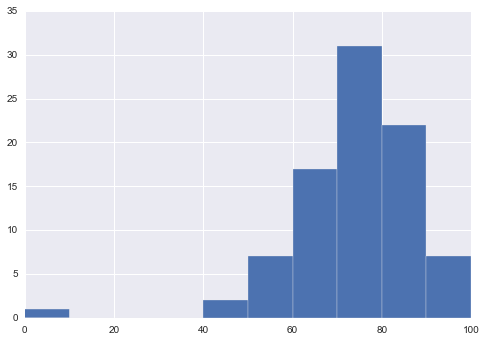

In [21]:
study_vars.p_male.hist()

Proportion missing

In [22]:
study_vars.isnull().mean(0).round(2)

Year        0.00
age_cat     0.00
country     0.00
age_mean    0.10
age_sd      0.19
age_min     0.06
age_max     0.07
p_male      0.02
dtype: float64

Will assume the mean age for those which are missing is simply the midpoint between minimum and maximum values

In [23]:
est_means = study_vars.apply(lambda x: x.age_min + (x.age_max - x.age_min) / 2, axis=1)[study_vars.age_mean.isnull()]
study_vars.loc[study_vars.age_mean.isnull(), 'age_mean'] = est_means

study_vars.age_mean.isnull().sum()

2

In [24]:
outcomes_varnames = ['Ref ID', 'Measure Instrument', 'instrument', 'subtype', 'units', 
                     'intvn', 'cc', 'pc', 'fc',
                     'BL N', 'BL Mean', 'BL SD', 
                     'EOT \nN', 'EOT Mean', 'EOT \nSD', 'Last FU Time', 'Last FU N', 
                     'Last FU Mean', 'Last FU SD', 'CS Group N', 'CS Mean', 'CS SD']

In [25]:
outcomes_vars = outcomes[outcomes_varnames].rename(columns={'Ref ID': 'RefID', 
                                                                       'Measure Instrument': 'measure_instrument',
                                                                       'cc': 'child_component',
                                                                       'pc': 'parent_component',
                                                                       'fc': 'family_component',
                                                                       'oc': 'other_component',
                                                                       'BL N': 'baseline_n',
                                                                       'BL Mean': 'baseline_mean',
                                                                       'BL SD': 'baseline_sd', 
                                                                       'EOT \nN': 'end_treat_n', 
                                                                       'EOT Mean': 'end_treat_mean', 
                                                                       'EOT \nSD': 'end_treat_sd', 
                                                                       'Last FU Time': 'followup_time', 
                                                                       'Last FU N': 'followup_n',
                                                                       'Last FU Mean': 'followup_mean', 
                                                                       'Last FU SD': 'followup_sd', 
                                                                       'CS Group N': 'change_n',
                                                                       'CS Mean': 'change_mean',
                                                                       'CS SD': 'change_sd'})

Recode intervention clasification

In [26]:
outcomes_vars.isnull().sum()

RefID                   0
measure_instrument      0
instrument              0
subtype                 0
units                   0
intvn                   0
child_component         0
parent_component        0
family_component        0
baseline_n              4
baseline_mean          17
baseline_sd            25
end_treat_n            74
end_treat_mean         67
end_treat_sd           74
followup_time          32
followup_n            103
followup_mean         118
followup_sd           126
change_n              241
change_mean           248
change_sd             253
dtype: int64

In [27]:
control = ((outcomes_vars.child_component^True) & 
           (outcomes_vars.parent_component^True) & 
           (outcomes_vars.family_component^True)).astype(int)
child_only = ((outcomes_vars.child_component) & 
              (outcomes_vars.parent_component^True) & 
              (outcomes_vars.family_component^True)).astype(int)
parent_only = ((outcomes_vars.child_component^True) & 
               (outcomes_vars.parent_component) & 
               (outcomes_vars.family_component^True)).astype(int)
outcomes_vars.ix[child_only.astype(bool), ['child_component', 'parent_component', 'family_component']]

,child_component,parent_component,family_component
125,1,0,0
126,1,0,0
128,1,0,0
129,1,0,0
162,1,0,0
188,1,0,0
194,1,0,0
195,1,0,0
234,1,0,0
236,1,0,0


In [28]:
multi_component = ((parent_only^True) & (child_only^True) & (control^True)).astype(int)

outcomes_vars['child_only'] = child_only
outcomes_vars['parent_only'] = parent_only
outcomes_vars['multi_component'] = multi_component

Obtain subset with non-missing EOT data

In [29]:
eot_subset = outcomes_vars[outcomes_vars.end_treat_mean.notnull() & outcomes_vars.end_treat_sd.notnull()].copy()

Calculate EOT difference

In [30]:
eot_subset['eot_diff_mean'] = eot_subset.end_treat_mean - eot_subset.baseline_mean

In [31]:
eot_subset['eot_diff_sd'] = eot_subset.baseline_sd + eot_subset.end_treat_sd

In [32]:
eot_subset['eot_diff_n'] = eot_subset[['baseline_n', 'end_treat_n']].min(1)

Distribution of baseline means among outcome metrics

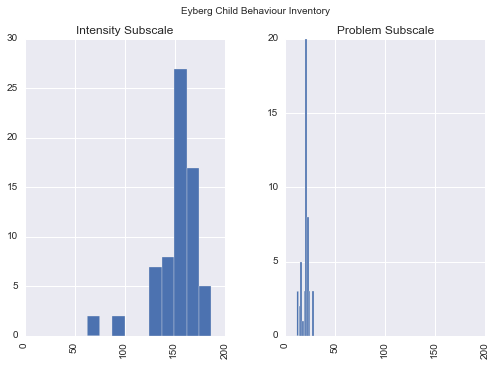

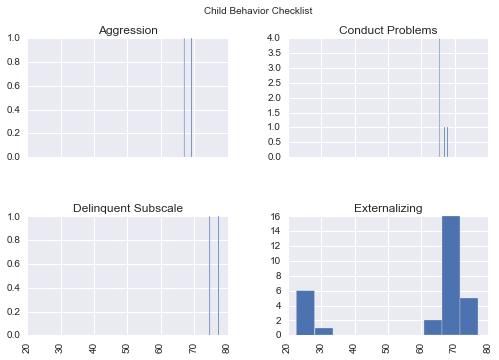

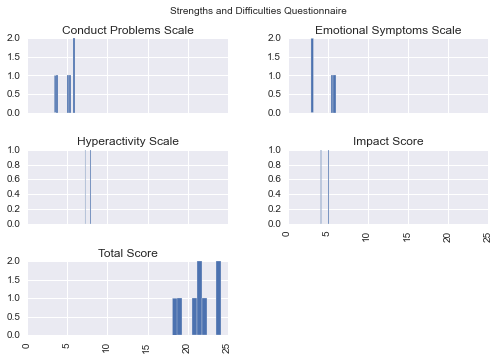

In [33]:
for instrument in ('Eyberg Child Behaviour Inventory', 
                   'Child Behavior Checklist', 
                   'Strengths and Difficulties Questionnaire'):
    eot_subset[eot_subset.instrument==instrument]['baseline_mean'].hist(by=eot_subset['subtype'], 
                                                                              sharex=True)
    plt.suptitle(instrument);

In [34]:
eot_subset.instrument.value_counts()

Eyberg Child Behaviour Inventory            116
Child Behavior Checklist                     40
Strengths and Difficulties Questionnaire     22
dtype: int64

In [35]:
eot_subset[eot_subset.RefID==441]

,RefID,measure_instrument,instrument,subtype,units,intvn,child_component,parent_component,family_component,baseline_n,...,followup_sd,change_n,change_mean,change_sd,child_only,parent_only,multi_component,eot_diff_mean,eot_diff_sd,eot_diff_n
14,441,"Eyberg Child Behaviour Inventory, Intensity Su...",Eyberg Child Behaviour Inventory,Intensity Subscale,Scale,iypt,0,1,0,32,...,NaN,NaN,NaN,NaN,0,1,0,-31.40,46.80,32
15,441,"Eyberg Child Behaviour Inventory, Intensity Su...",Eyberg Child Behaviour Inventory,Intensity Subscale,Scale,wlc,0,0,0,20,...,NaN,NaN,NaN,NaN,0,0,0,-5.80,49.60,20
16,441,"Eyberg Child Behaviour Inventory, Problem Subs...",Eyberg Child Behaviour Inventory,Problem Subscale,Scale,iypt,0,1,0,24,...,NaN,NaN,NaN,NaN,0,1,0,-9.70,12.02,24
17,441,"Eyberg Child Behaviour Inventory, Problem Subs...",Eyberg Child Behaviour Inventory,Problem Subscale,Scale,wlc,0,0,0,17,...,NaN,NaN,NaN,NaN,0,0,0,-2.88,14.59,17


Several studies use multiple instruments and metrics within instruments

In [36]:
eot_subset.groupby(['RefID', 'instrument'])['subtype'].value_counts()

RefID  instrument                                                  
103    Eyberg Child Behaviour Inventory          Problem Subscale      2
                                                 Intensity Subscale    2
371    Eyberg Child Behaviour Inventory          Problem Subscale      2
                                                 Intensity Subscale    2
441    Eyberg Child Behaviour Inventory          Problem Subscale      2
                                                 Intensity Subscale    2
475    Eyberg Child Behaviour Inventory          Intensity Subscale    2
539    Child Behavior Checklist                  Externalizing         2
                                                 Aggression            2
564    Eyberg Child Behaviour Inventory          Problem Subscale      2
                                                 Intensity Subscale    2
836    Strengths and Difficulties Questionnaire  Total Score           2
899    Child Behavior Checklist                  Externa

In [37]:
pd.crosstab(eot_subset.instrument, eot_subset.subtype)

subtype,Aggression,Conduct Problems,Conduct Problems Scale,Delinquent Subscale,Emotional Symptoms Scale,Externalizing,Hyperactivity Scale,Impact Score,Intensity Subscale,Problem Subscale,Total Score
instrument,,,,,,,,,,,
Child Behavior Checklist,2,6,0,2,0,30,0,0,0,0,0
Eyberg Child Behaviour Inventory,0,0,0,0,0,0,0,0,68,48,0
Strengths and Difficulties Questionnaire,0,0,6,0,4,0,2,2,0,0,8


In [38]:
x = eot_subset[eot_subset.instrument=='Eyberg Child Behaviour Inventory']
pd.crosstab(x.instrument, x.subtype)

subtype,Intensity Subscale,Problem Subscale
instrument,,
Eyberg Child Behaviour Inventory,68,48


In [39]:
x = eot_subset[eot_subset.instrument=='Child Behavior Checklist']
pd.crosstab(x.instrument, x.subtype)

subtype,Aggression,Conduct Problems,Delinquent Subscale,Externalizing
instrument,,,,
Child Behavior Checklist,2,6,2,30


In [40]:
x = eot_subset[eot_subset.instrument=='Strengths and Difficulties Questionnaire']
pd.crosstab(x.instrument, x.subtype)

subtype,Conduct Problems Scale,Emotional Symptoms Scale,Hyperactivity Scale,Impact Score,Total Score
instrument,,,,,
Strengths and Difficulties Questionnaire,6,4,2,2,8


Merge study variables and outcomes

In [41]:
merged_vars = study_vars.merge(eot_subset, left_index=True, right_on='RefID')
merged_vars.shape

(176, 36)

For now, restrict to the three most prevalent metrics.

In [42]:
merged_vars.measure_instrument.value_counts()

Eyberg Child Behaviour Inventory, Intensity Subscale            64
Eyberg Child Behaviour Inventory, Problem Subscale              48
Child Behavior Checklist, Externalizing (T Score)               21
Strengths and Difficulties Questionnaire, Total Score            8
Child Behavior Checklist, Externalizing                          7
Child Behavior Checklist, Conduct Problems (T Score)             6
Strengths and Difficulties Questionnaire- Conduct Problems Scale     6
Eyberg Child Behaviour Inventory, Intensity Subscale (T Score)     4
Strengths and Difficulties Questionnaire- Emotional Symptoms Scale     4
Strengths and Difficulties Questionnaire- Hyperactivity Scale     2
Strengths and Difficulties Questionnaire- Impact Score           2
Child Behavior Checklist, Delinquent Subscale                    2
Child Behavior Checklist, Aggression                             2
dtype: int64

Take only the top 3 measures

In [43]:
top_measures = 3

In [44]:
merged_vars.RefID.unique()

array([ 103,  371,  441,  475,  539,  564,  836,  899,  993, 1236, 1245,
       1511, 1585, 1875, 1951, 2092, 2117, 2219, 2239, 2347, 3211, 3225,
       3399, 3495, 3687, 3716, 3766, 3915, 3960, 7109, 7723, 8192, 8231,
       8289, 8292, 8401])

In [45]:
analysis_subset = merged_vars[merged_vars.measure_instrument.isin(merged_vars.measure_instrument.value_counts().index[:top_measures])]
analysis_subset.groupby('measure_instrument')['baseline_mean'].max()

measure_instrument
Child Behavior Checklist, Externalizing (T Score)        77.10
Eyberg Child Behaviour Inventory, Intensity Subscale    186.44
Eyberg Child Behaviour Inventory, Problem Subscale       28.62
Name: baseline_mean, dtype: float64

measure_instrument
Child Behavior Checklist, Externalizing (T Score)       Axes(0.125,0.125;0.775x0.775)
Eyberg Child Behaviour Inventory, Intensity Subscale    Axes(0.125,0.125;0.775x0.775)
Eyberg Child Behaviour Inventory, Problem Subscale      Axes(0.125,0.125;0.775x0.775)
Name: baseline_mean, dtype: object

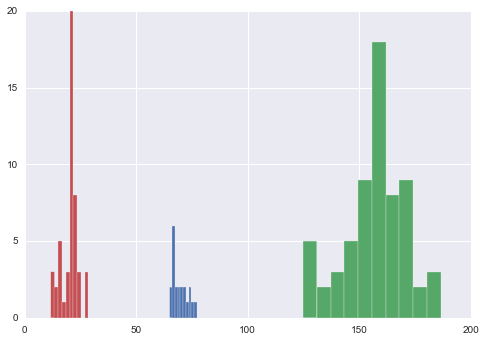

In [46]:
analysis_subset.groupby('measure_instrument').baseline_mean.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116fe2550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1171892e8>]], dtype=object)

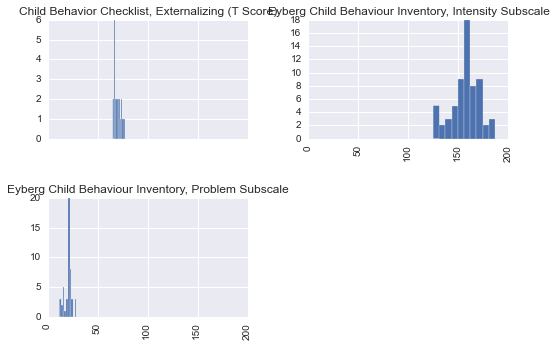

In [47]:
analysis_subset['baseline_mean'].hist(by=analysis_subset['measure_instrument'],sharex=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116a82860>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1169e3588>]], dtype=object)

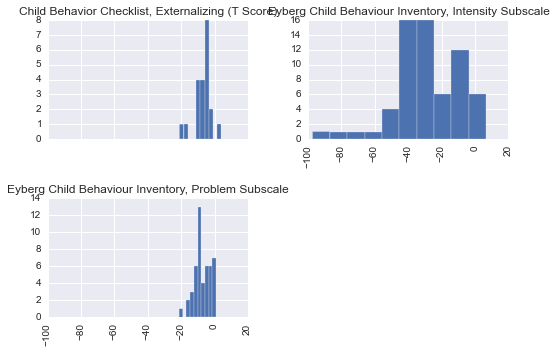

In [48]:
analysis_subset['eot_diff_mean'].hist(by=analysis_subset['measure_instrument'],sharex=True)

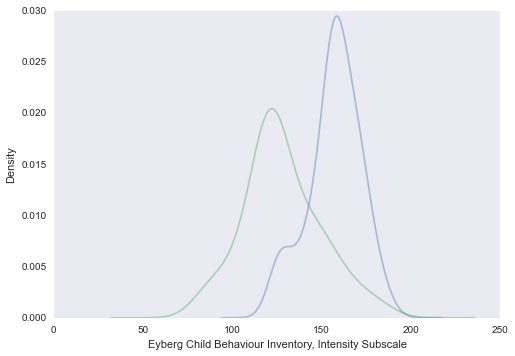

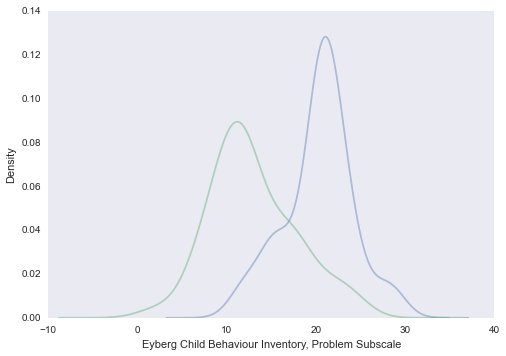

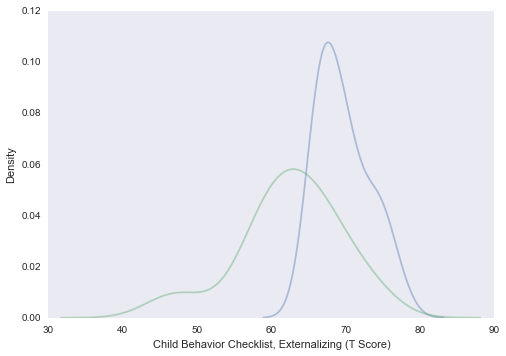

In [49]:
for x in analysis_subset.measure_instrument.unique():
    plt.figure()
    analysis_subset[analysis_subset.measure_instrument==x].baseline_mean.plot(kind='kde', alpha=0.4, grid=False)
    analysis_subset[analysis_subset.measure_instrument==x].end_treat_mean.plot(kind='kde', alpha=0.4, grid=False)
    plt.gca().set_xlabel(x)

## Meta-analysis

Number of studies in analysis subset

In [50]:
unique_studies = analysis_subset.RefID.unique().tolist()
len(unique_studies)

30

In [51]:
analysis_subset.RefID.unique()

array([ 103,  371,  441,  539,  564,  899, 1236, 1245, 1511, 1585, 1875,
       2092, 2117, 2219, 3211, 3225, 3399, 3495, 3687, 3716, 3766, 3915,
       3960, 7109, 7723, 8192, 8231, 8289, 8292, 8401])

In [52]:
analysis_subset.groupby(['RefID', 'measure_instrument'])['measure_instrument'].count().unstack().fillna(0)

measure_instrument,"Child Behavior Checklist, Externalizing (T Score)","Eyberg Child Behaviour Inventory, Intensity Subscale","Eyberg Child Behaviour Inventory, Problem Subscale"
RefID,,,
103,0,2,2
371,0,2,2
441,0,2,2
539,2,0,0
564,0,2,2
899,3,3,3
1236,0,6,6
1245,2,0,0
1511,3,0,0


Study counts by 

In [54]:
data_by_refid = analysis_subset.groupby('RefID')
data_by_refid.apply(lambda x: (x[['child_component', 'parent_component', 'multi_component']].sum()>1)).sum()

child_component      9
parent_component    22
multi_component      8
dtype: int64

In [55]:
data_by_refid.apply(lambda x: (x[['child_component', 'parent_component', 'multi_component']].sum(1)==0).sum()>0).astype(int)

RefID
103      0
371      1
441      1
539      1
564      1
899      1
1236     1
1245     0
1511     1
1585     1
1875     1
2092     1
2117     1
2219     1
3211     1
3225     1
3399     1
3495     1
3687     1
3716     1
3766     1
3915     1
3960     0
7109     1
7723     1
8192     1
8231     1
8289     0
8292     1
8401     1
dtype: int64

In [56]:
data_by_refid.apply(lambda x: x.age_cat.unique()[0]).value_counts()

1    17
0    11
2     2
dtype: int64

We are restricting the analysis to the 4 most prevalent measure instruments in the database.

In [57]:
unique_measures = analysis_subset.measure_instrument.unique().tolist()
k = len(unique_measures)
unique_measures

['Eyberg Child Behaviour Inventory, Intensity Subscale',
 'Eyberg Child Behaviour Inventory, Problem Subscale',
 'Child Behavior Checklist, Externalizing (T Score)']

Three intervention components were coded:

* `child_component`
* `parent_component`
* `multi_component`

In [58]:
p_male, age_cat, intvn = analysis_subset[['p_male', 'age_cat', 'intvn']].values.T
child_only, parent_only, multi_component = analysis_subset[['child_only', 'parent_only', 
                                                                       'multi_component']].values.T

change_n, change_mean, change_sd = analysis_subset[['eot_diff_n', 'eot_diff_mean', 'eot_diff_sd']].values.T

In [59]:
school = (analysis_subset.age_cat.values==0).astype(int)
pre_k = (analysis_subset.age_cat.values==1).astype(int)
teen = (analysis_subset.age_cat.values==2).astype(int)

The response variable is a multivariate normal of dimension k=3, for each of the measure instruments:

1. Eyberg Child Behaviour Inventory, Intensity Subscale
2. Eyberg Child Behaviour Inventory, Problem Subscale
3. Child Behavior Checklist, Externalizing (T Score)

$$\left({
\begin{array}{c}
  {m_1}\\
  {m_2}\\
  {m_3}
\end{array}
}\right)_i \sim\text{MVN}(\mathbf{\mu},\Sigma)$$

Means for each study are a draw from a multivariate normal.

In [60]:
wishart = False

mu = pm.Normal('mu', 0, 0.001, value=[0]*k)

if wishart:
    T = pm.Wishart('T', k+1, np.eye(k), value=np.eye(k))
    
    m = [pm.MvNormal('m_{}'.format(i), mu, T, value=[0]*k) for i in range(len(unique_studies))]
else:
    sigmas = pm.Uniform('sigmas', 0, 100, value=[10]*k)
    rhos = pm.Uniform('rhos', -1, 1, value=[0]*int(comb(k, 2)))

    Sigma = pm.Lambda('Sigma', lambda s=sigmas, r=rhos: np.array([[s[0]**2, s[0]*s[1]*r[0], s[0]*s[2]*r[1]],
                                                                 [s[0]*s[1]*r[0], s[1]**2, s[1]*s[2]*r[2]],
                                                                 [s[0]*s[2]*r[1], s[1]*s[2]*r[2], s[2]**2]]))
    
    m = [pm.MvNormalCov('m_{}'.format(i), mu, Sigma, value=[0]*k) for i in range(len(unique_studies))]



Unique intervention labels for each component; we will use these for component random effects.

In [61]:
unique_child_intvn = np.unique(intvn[child_only.astype(bool)]).tolist()
unique_parent_intvn = np.unique(intvn[parent_only.astype(bool)]).tolist()
unique_multi_intvn = np.unique(intvn[multi_component.astype(bool)]).tolist()

In [62]:
# Indices to random effect labels
child_component_index = [unique_child_intvn.index(x) for x in intvn[child_only.astype(bool)]]
parent_component_index = [unique_parent_intvn.index(x) for x in intvn[parent_only.astype(bool)]]
multi_component_index = [unique_multi_intvn.index(x) for x in intvn[multi_component.astype(bool)]]

Treatment component random effects

$$X_i = \left[{
\begin{array}{c}
  {x_c}\\
  {x_p}\\
  {x_m}\\
\end{array}
}\right]_i$$

$$\begin{aligned}
\beta_j^{(c)} &\sim N(\mu_{\beta}^{(c)},\tau_{\beta}^{(c)}) \\
\beta_j^{(p)} &\sim N(\mu_{\beta}^{(p)},\tau_{\beta}^{(p)}) \\
\beta_j^{(m)} &\sim N(\mu_{\beta}^{(m)},\tau_{\beta}^{(m)})
\end{aligned}$$

In [63]:
mu_beta = pm.Normal('mu_beta', 0, 0.001, value=[0]*3)
# sig_beta = pm.Uniform('sig_beta', 0, 100, value=1)
# tau_beta = sig_beta ** -2
tau_beta = pm.Gamma('tau_beta', 1, 0.1, value=1)

beta_c = pm.Normal('beta_c', mu_beta[0], tau_beta, value=[0]*len(unique_child_intvn))
beta_p = pm.Normal('beta_p', mu_beta[1], tau_beta, value=[0]*len(unique_parent_intvn))
beta_m = pm.Normal('beta_m', mu_beta[2], tau_beta, value=[0]*len(unique_multi_intvn))

b_c = pm.Lambda('b_c', lambda b=beta_c: 
             np.array([b[unique_child_intvn.index(x)] if child_only[i] else 0 for i,x in enumerate(intvn)]))
b_p = pm.Lambda('b_p', lambda b=beta_p: 
             np.array([b[unique_parent_intvn.index(x)] if parent_only[i] else 0 for i,x in enumerate(intvn)]))
b_m = pm.Lambda('b_m', lambda b=beta_m: 
             np.array([b[unique_multi_intvn.index(x)] if multi_component[i] else 0 for i,x in enumerate(intvn)]))


Calculate the probability of being the best intervention.

In [64]:
best = pm.Lambda('best', lambda b=mu_beta:  (b==b.min()).astype(int))

Interaction of parent and multi-component with pre-k children.

In [65]:
interaction = False

if interaction:
    beta_pk_p = pm.Normal('beta_pk_p', 0, 1e-5, value=0)
    beta_pk_m = pm.Normal('beta_pk_m', 0, 1e-5, value=0)
    b_pk_p = pm.Lambda('b_pk_p', lambda b=beta_pk_p: b * parent_only * pre_k)
    b_pk_m = pm.Lambda('b_pk_m', lambda b=beta_pk_m: b * multi_component * pre_k)

In [66]:
betas = b_c + b_p + b_m 

if interaction:
    betas = betas + b_pk_p + b_pk_m

Covariate effects of age and percent female.

$$\alpha \sim N(0, 1e5)$$

In [67]:
alpha_age = pm.Normal('alpha_age', 0, 1e-5, value=[1,2])

Unique study ID (`RefID`) and measure ID (`measure_instrument`) values.

In [68]:
study_id = [unique_studies.index(x) for x in analysis_subset.RefID]
measure_id = [unique_measures.index(x) for x in analysis_subset.measure_instrument]

Calculate expected response (treatment difference) as a function of treatment and covariates.

$$\theta_i = m_{j[i]k} + X_i \beta + \alpha x_{age}$$ 

In [69]:
baseline_sd = analysis_subset.baseline_sd.values

@pm.deterministic
def theta(m=m, betas=betas, alpha_age=alpha_age):  

    mi = [m[i][j] for i,j in zip(study_id, measure_id)]
    
    age_effect = np.array([alpha_age[a-1] if a else 0 for a in age_cat])
    
    return(mi + baseline_sd*(betas + age_effect))

Expected treatment effect for pre-K undergoing multi-component intervention, measused by Eyberg Child Behaviour Inventory, Intensity Subscale

In [70]:
if wishart:
    baseline = pm.MvNormal('baseline', mu, T, value=[0]*k)
else:
    baseline = pm.MvNormalCov('baseline', mu, Sigma, value=[0]*k)

Calculation of expected differences from baseline for each instrument.

In [71]:
# ECBI intensity subscale
ecbi_intensity_sd = baseline_sd[np.array(measure_id)==0].mean()

prek_intensity_pred = pm.Lambda('prek_intensity_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[0] + ecbi_intensity_sd*(b + a[0]) )
school_intensity_pred = pm.Lambda('school_intensity_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[0] + ecbi_intensity_sd*b )
teen_intensity_pred = pm.Lambda('teen_intensity_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[0] + ecbi_intensity_sd*(b + a[1]) )

intensity_diff = pm.Lambda('intensity_diff', 
                           lambda base=baseline, prek=prek_intensity_pred, school=school_intensity_pred, 
                           teen=teen_intensity_pred: np.array([prek, school, teen])-base[0])
                            

# ECBI problem subscale
ecbi_problem_sd = baseline_sd[np.array(measure_id)==1].mean()

prek_problem_pred = pm.Lambda('prek_problem_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[1] + ecbi_problem_sd*(b + a[0]) )
school_problem_pred = pm.Lambda('school_problem_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[1] + ecbi_problem_sd*b )
teen_problem_pred = pm.Lambda('teen_problem_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[1] + ecbi_problem_sd*(b + a[1]) )

problem_diff = pm.Lambda('problem_diff', 
                           lambda base=baseline, prek=prek_problem_pred, school=school_problem_pred, 
                           teen=teen_problem_pred: np.array([prek, school, teen])-base[1])

# CBC T-score
cbct_sd = baseline_sd[np.array(measure_id)==2].mean()

prek_tscore_pred = pm.Lambda('prek_tscore_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[2] + cbct_sd*(b + a[0]) )
school_tscore_pred = pm.Lambda('school_tscore_pred', 
                            lambda mu=baseline, b=mu_beta: mu[2] + cbct_sd*b )
teen_tscore_pred = pm.Lambda('teen_tscore_pred', 
                            lambda mu=baseline, a=alpha_age, b=mu_beta: mu[2] + cbct_sd*(b + a[1]) )

tscore_diff = pm.Lambda('tscore_diff', 
                           lambda base=baseline, prek=prek_tscore_pred, school=school_tscore_pred, 
                           teen=teen_tscore_pred: np.array([prek, school, teen])-base[2])

Finally, the likelihood is just a normal distribution, with the observed standard error of the treatment effect as the standard deviation of the estimates.

$$d_i \sim N(\theta_i, \hat{\sigma}^2)$$

In [72]:
change_se = change_sd/np.sqrt(change_n)

In [73]:
d = pm.Normal('d', theta, change_se**-2, observed=True, value=change_mean)

Posterior predictive samples, if desired.

In [74]:
include_gof_samples = False

if include_gof_samples:
    d_sim = pm.Normal('d_sim', theta, change_se**-2, size=len(change_mean))

Instantiate MCMC model, and use Adaptive Metropolis for some vector-valued variables.

In [75]:
M = pm.MCMC(locals())
M.use_step_method(pm.AdaptiveMetropolis, m)
M.use_step_method(pm.AdaptiveMetropolis, mu_beta)
M.use_step_method(pm.AdaptiveMetropolis, [beta_c, beta_p, beta_m])

Run two chains to allow for convergence evaluation.

In [76]:
M.sample(100000, 90000)

 [-----------------100%-----------------] 100000 of 100000 complete in 823.3 sec

In [100]:
M.sample(100000, 90000)

 [-----------------100%-----------------] 100000 of 100000 complete in 302.6 sec

Summary of estimates of intervention components

In [77]:
if wishart:
    pm.Matplot.plot(T)

Plotting mu_beta_0
Plotting mu_beta_1
Plotting mu_beta_2


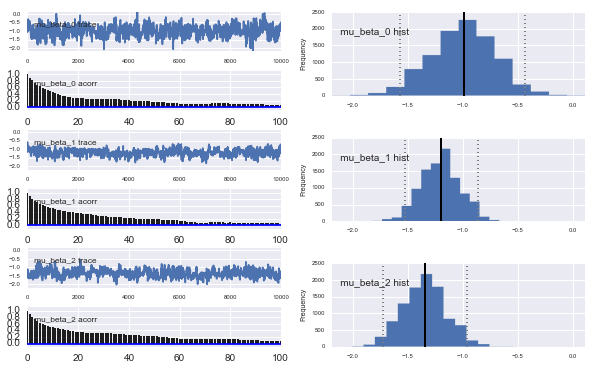

In [78]:
pm.Matplot.plot(mu_beta)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


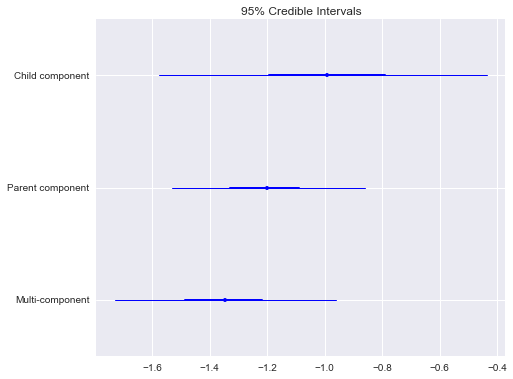

In [79]:
pm.Matplot.summary_plot([mu_beta], custom_labels=['Child component', 'Parent component', 
                                                              'Multi-component'])

In [80]:
mu_beta.summary()


mu_beta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-1.003           0.297            0.017            [-1.576 -0.437]
	-1.204           0.178            0.01             [-1.531 -0.859]
	-1.347           0.201            0.012            [-1.73  -0.962]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-1.583           -1.195          -0.992         -0.791        -0.437
	-1.545           -1.328          -1.2           -1.09         -0.863
	-1.72            -1.485          -1.347         -1.218        -0.951
	


In [81]:
best.summary()


best:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.124            0.329            0.015                  [ 0.  1.]
	0.238            0.426            0.019                  [ 0.  1.]
	0.639            0.48             0.024                  [ 0.  1.]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.0              0.0             0.0            0.0           1.0
	0.0              0.0             0.0            0.0           1.0
	0.0              0.0             1.0            1.0           1.0
	


Plotting mu_beta_0
Plotting mu_beta_1
Plotting mu_beta_2


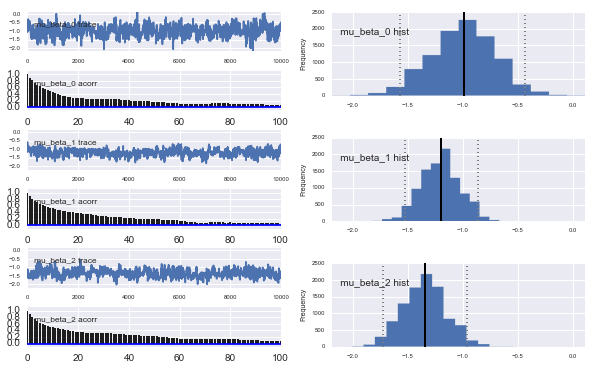

In [82]:
pm.Matplot.plot(mu_beta)

In [83]:
if interaction:
    pm.Matplot.summary_plot([beta_pk_m, beta_pk_p])

Difference means by measure instrument.

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


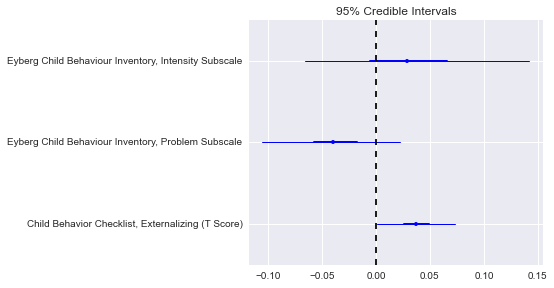

In [84]:
plt.figure(figsize=(24,4))
pm.Matplot.summary_plot([mu], custom_labels=unique_measures)

Plotting mu_0
Plotting mu_1
Plotting mu_2


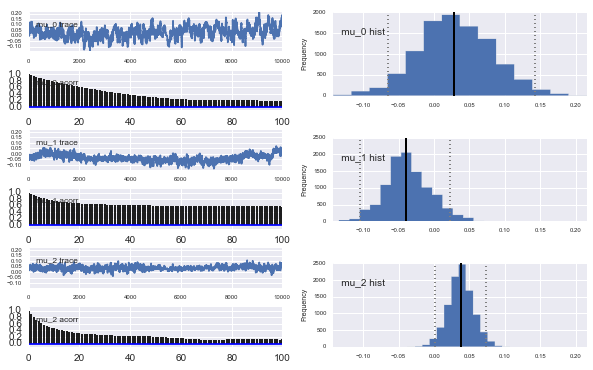

In [85]:
pm.Matplot.plot(mu)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


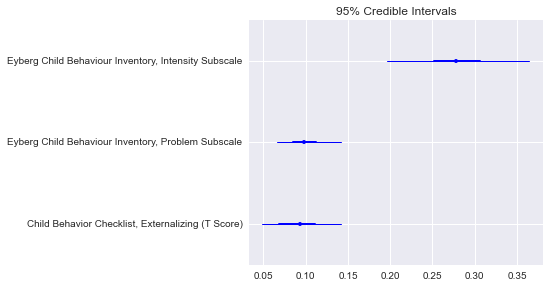

In [86]:
if not wishart:
    plt.figure(figsize=(24,4))
    pm.Matplot.summary_plot([sigmas], custom_labels=unique_measures)

In [87]:
sigmas.summary()


sigmas:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.281            0.043            0.003            [ 0.196  0.365]
	0.1              0.02             0.002            [ 0.066  0.142]
	0.092            0.026            0.002            [ 0.049  0.141]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.206            0.252           0.278          0.306         0.38
	0.067            0.085           0.098          0.113         0.144
	0.051            0.069           0.093          0.111         0.147
	


Plotting sigmas_0
Plotting sigmas_1
Plotting sigmas_2


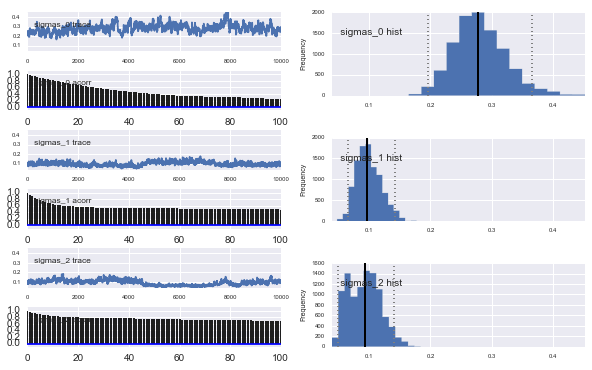

In [88]:
pm.Matplot.plot(sigmas)

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


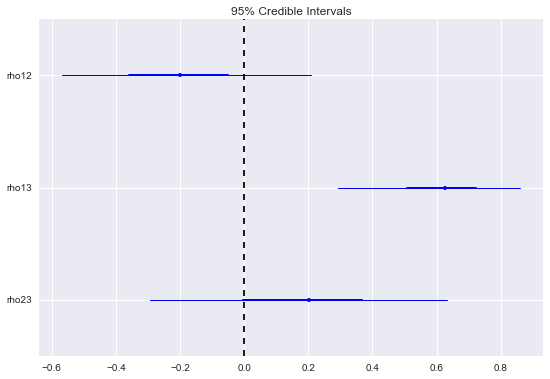

In [89]:
if not wishart:
    pm.Matplot.summary_plot([rhos], custom_labels=['rho12', 'rho13', 'rho23'])

Age effects for pre-k (top) and teen (bottom) groups, relative to pre-teen.

Could not calculate Gelman-Rubin statistics. Requires multiple chains of equal length.


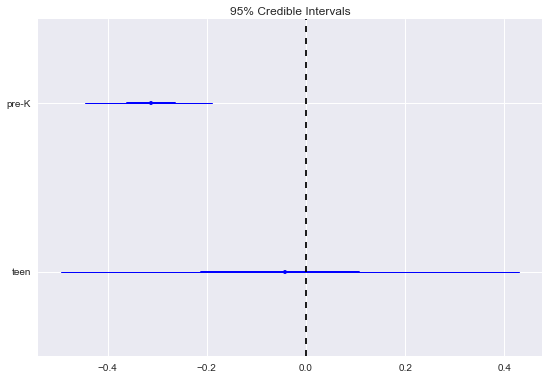

In [90]:
pm.Matplot.summary_plot([alpha_age], custom_labels=['pre-K', 'teen'])

In [91]:
alpha_age.summary()


alpha_age:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-0.313           0.068            0.004            [-0.445 -0.19 ]
	-0.054           0.241            0.016            [-0.495  0.43 ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.442           -0.36           -0.312         -0.265        -0.182
	-0.539           -0.212          -0.042         0.107         0.406
	


Plotting alpha_age_0
Plotting alpha_age_1


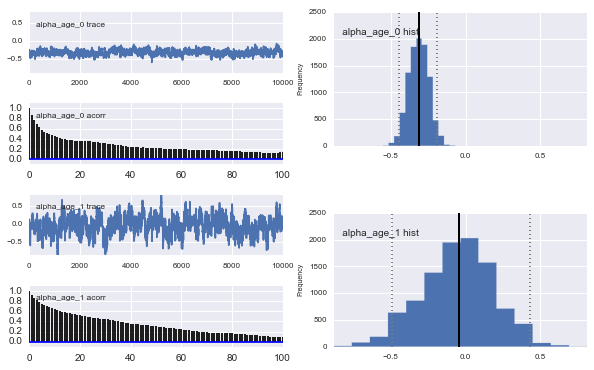

In [92]:
pm.Matplot.plot(alpha_age)

## Outcome Plots

In [94]:
traces = [[school_intensity_pred, prek_intensity_pred, teen_intensity_pred],
          [school_problem_pred, prek_problem_pred, teen_problem_pred],
          [school_tscore_pred, prek_tscore_pred, teen_tscore_pred]]

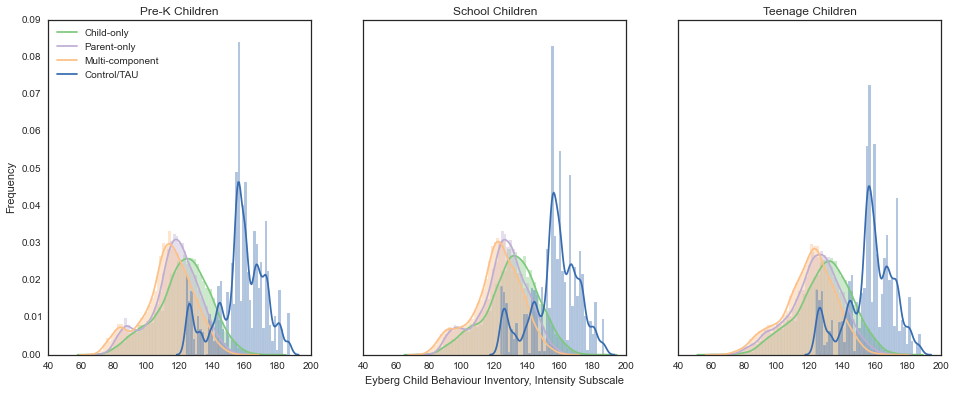

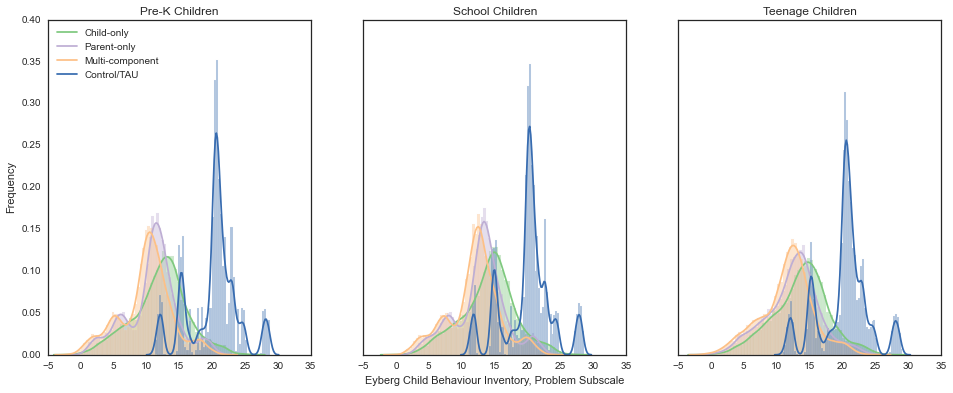

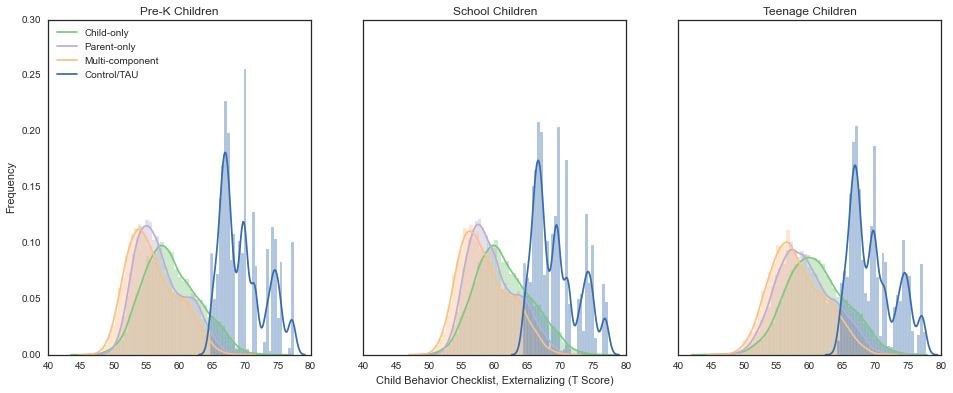

In [96]:
sb.set(style="white", palette="hot")
sb.despine(left=True)

colors = '#7fc97f','#beaed4','#fdc086','#386cb0'
#colors = '#a6611a','#dfc27d','#80cdc1','#018571'
# colors = ('#fef0d9','#fdcc8a','#fc8d59','#d7301f')[::-1]
# colors = sb.cubehelix_palette(4, start=2, rot=0, dark=.25, light=.75, reverse=False)

titles = ['Pre-K Children', 'School Children', 'Teenage Children']

for i,measure in enumerate(unique_measures):
    
    f, axes = plt.subplots(1, 3, figsize=(16, 6), sharex=True, sharey=True)
    measure_traces = traces[i]
    
    for j, trace in enumerate(np.array(measure_traces)[[1,0,2]]):
        
        x = np.random.choice(analysis_subset[analysis_subset.measure_instrument==measure].baseline_mean, 10000)
        
        c1, p1, m1 = trace.trace().T
        
        g = sb.distplot(x + c1, color=colors[0], ax=axes[j])
        sb.distplot(x + p1, color=colors[1], ax=axes[j])
        sb.distplot(x + m1, color=colors[2], ax=axes[j])
        if j:
            age_effect = alpha_age.trace()[:, j-1]
        else:
            age_effect = 0
        sb.distplot(x + baseline.trace()[:, i] + age_effect, color=colors[3], ax=axes[j]);
        g.set_title(titles[j])

        

        if not j:
            g.set_ylabel('Frequency')
            g.legend(g.lines, ['Child-only', 'Parent-only', 'Multi-component', 'Control/TAU'], loc='upper left')
        if j==1:
            g.set_xlabel(measure)

Generate threshold proportions

In [97]:
thresholds = [127, # ECBI, intensity
              11,  # ECBI, problem
              60]  # CBC t-score

age_labels = ['school', 'pre-k', 'teen']

estimates = []

for i,measure in enumerate(unique_measures):
    
    measure_traces = traces[i]
    cutoff = thresholds[i]
    
    for j, trace in enumerate(measure_traces):
        
        x = np.random.choice(analysis_subset[analysis_subset.measure_instrument==measure].baseline_mean, 10000)
        
        c1, p1, m1 = trace.trace().T
        
        _child_only = ((x + c1) > cutoff).mean().round(2)
        _parent_only = ((x + p1) > cutoff).mean().round(2)
        _multi_component = ((x + m1) > cutoff).mean().round(2)
        if j:
            age_effect = alpha_age.trace()[:, j-1]
        else:
            age_effect = 0
        _control = ((x + baseline.trace()[:, i] + age_effect) > cutoff).mean().round(2)
        
        print('\n{0}, {1}'.format(measure, age_labels[j]))
        print('Child-only: {0}\nParent-only: {1}\nMulti-component: {2}\nControl/TAU: {3}'.format(_child_only, 
                                                                                                 _parent_only,
                                                                                                 _multi_component,
                                                                                                 _control))
        
        estimates.append((measure, age_labels[j], _child_only, _parent_only, _multi_component, _control))
        


Eyberg Child Behaviour Inventory, Intensity Subscale, school
Child-only: 0.63
Parent-only: 0.48
Multi-component: 0.37
Control/TAU: 0.94

Eyberg Child Behaviour Inventory, Intensity Subscale, pre-k
Child-only: 0.41
Parent-only: 0.26
Multi-component: 0.18
Control/TAU: 0.94

Eyberg Child Behaviour Inventory, Intensity Subscale, teen
Child-only: 0.59
Parent-only: 0.45
Multi-component: 0.34
Control/TAU: 0.94

Eyberg Child Behaviour Inventory, Problem Subscale, school
Child-only: 0.79
Parent-only: 0.75
Multi-component: 0.68
Control/TAU: 1.0

Eyberg Child Behaviour Inventory, Problem Subscale, pre-k
Child-only: 0.65
Parent-only: 0.55
Multi-component: 0.4
Control/TAU: 1.0

Eyberg Child Behaviour Inventory, Problem Subscale, teen
Child-only: 0.76
Parent-only: 0.7
Multi-component: 0.62
Control/TAU: 1.0

Child Behavior Checklist, Externalizing (T Score), school
Child-only: 0.59
Parent-only: 0.41
Multi-component: 0.33
Control/TAU: 1.0

Child Behavior Checklist, Externalizing (T Score), pre-k
Chil

In [98]:
thresholds = [127, # ECBI, intensity
              11,  # ECBI, problem
              60]  # CBC t-score

age_labels = ['school', 'pre-k', 'teen']

estimates = []

for i,measure in enumerate(unique_measures):
    
    measure_traces = traces[i]
    cutoff = thresholds[i]
    
    for j, trace in enumerate(measure_traces):
        
        x = np.random.choice(analysis_subset[analysis_subset.measure_instrument==measure].baseline_mean, 10000)
        
        c1, p1, m1 = trace.trace().T
        
        _child_only = ((x + c1) > cutoff).mean().round(2)
        _parent_only = ((x + p1) > cutoff).mean().round(2)
        _multi_component = ((x + m1) > cutoff).mean().round(2)
        if j:
            age_effect = alpha_age.trace()[:, j-1]
        else:
            age_effect = 0
        _control = ((x + baseline.trace()[:, i] + age_effect) > cutoff).mean().round(2)
        
        print('\n{0}, {1}'.format(measure, age_labels[j]))
        print('Child-only: {0}\nParent-only: {1}\nMulti-component: {2}\nControl/TAU: {3}'.format(_child_only, 
                                                                                                 _parent_only,
                                                                                                 _multi_component,
                                                                                                 _control))
        
        estimates.append((measure, age_labels[j], _child_only, _parent_only, _multi_component, _control))
        


Eyberg Child Behaviour Inventory, Intensity Subscale, school
Child-only: 0.63
Parent-only: 0.49
Multi-component: 0.38
Control/TAU: 0.94

Eyberg Child Behaviour Inventory, Intensity Subscale, pre-k
Child-only: 0.41
Parent-only: 0.25
Multi-component: 0.17
Control/TAU: 0.94

Eyberg Child Behaviour Inventory, Intensity Subscale, teen
Child-only: 0.59
Parent-only: 0.45
Multi-component: 0.35
Control/TAU: 0.94

Eyberg Child Behaviour Inventory, Problem Subscale, school
Child-only: 0.79
Parent-only: 0.75
Multi-component: 0.68
Control/TAU: 1.0

Eyberg Child Behaviour Inventory, Problem Subscale, pre-k
Child-only: 0.66
Parent-only: 0.56
Multi-component: 0.41
Control/TAU: 1.0

Eyberg Child Behaviour Inventory, Problem Subscale, teen
Child-only: 0.75
Parent-only: 0.69
Multi-component: 0.62
Control/TAU: 1.0

Child Behavior Checklist, Externalizing (T Score), school
Child-only: 0.6
Parent-only: 0.41
Multi-component: 0.33
Control/TAU: 1.0

Child Behavior Checklist, Externalizing (T Score), pre-k
Chi

In [99]:
estimates

[('Eyberg Child Behaviour Inventory, Intensity Subscale',
  'school',
  0.63,
  0.48999999999999999,
  0.38,
  0.93999999999999995),
 ('Eyberg Child Behaviour Inventory, Intensity Subscale',
  'pre-k',
  0.40999999999999998,
  0.25,
  0.17000000000000001,
  0.93999999999999995),
 ('Eyberg Child Behaviour Inventory, Intensity Subscale',
  'teen',
  0.58999999999999997,
  0.45000000000000001,
  0.34999999999999998,
  0.93999999999999995),
 ('Eyberg Child Behaviour Inventory, Problem Subscale',
  'school',
  0.79000000000000004,
  0.75,
  0.68000000000000005,
  1.0),
 ('Eyberg Child Behaviour Inventory, Problem Subscale',
  'pre-k',
  0.66000000000000003,
  0.56000000000000005,
  0.40999999999999998,
  1.0),
 ('Eyberg Child Behaviour Inventory, Problem Subscale',
  'teen',
  0.75,
  0.68999999999999995,
  0.62,
  1.0),
 ('Child Behavior Checklist, Externalizing (T Score)',
  'school',
  0.59999999999999998,
  0.40999999999999998,
  0.33000000000000002,
  1.0),
 ('Child Behavior Checklist,

In [100]:
np.savetxt('estimates.csv', np.array([e[2:] for e in estimates]), delimiter='\t', fmt='%1.2f')

In [101]:
pd.DataFrame(estimates, columns=['Instrument', 'Age group', 'Child-only', 
                                 'Parent-only', 'Multi-component', 'TAU/Control']).to_csv('outcome_proportions.csv')

Summary statistics for TAU/control

In [102]:
baseline.summary()


baseline:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.029            0.292            0.005            [-0.554  0.598]
	-0.036           0.107            0.003            [-0.251  0.172]
	0.037            0.097            0.001            [-0.17   0.224]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.543           -0.164          0.029          0.221         0.611
	-0.254           -0.105          -0.034         0.032         0.171
	-0.163           -0.022          0.036          0.096         0.236
	


Summary statistics for intensity subscale

In [103]:
prek_intensity_pred.summary()
school_intensity_pred.summary()
teen_intensity_pred.summary()


prek_intensity_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-34.869          7.982            0.429          [-50.713 -19.865]
	-40.213          4.617            0.241          [-48.969 -30.93 ]
	-44.005          5.4              0.296          [-54.266 -33.245]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-50.409          -40.298         -34.821        -29.35        -19.502
	-49.347          -43.37          -40.131        -37.091       -31.207
	-54.12           -47.74          -44.102        -40.668       -33.008
	

school_intensity_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-26.568          7.898            0.439          [-41.78  -11.401]
	-31.912          4.739   

Summary statistics for problem subscale

In [104]:
prek_problem_pred.summary()
school_problem_pred.summary()
teen_problem_pred.summary()


prek_problem_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-8.167           1.859            0.1            [-11.712  -4.517]
	-9.412           1.077            0.056          [-11.464  -7.283]
	-10.296          1.261            0.069          [-12.725  -7.801]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-11.78           -9.436          -8.16          -6.89         -4.577
	-11.508          -10.16          -9.399         -8.677        -7.311
	-12.664          -11.169         -10.316        -9.509        -7.716
	

school_problem_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-6.233           1.839            0.102            [-9.738 -2.685]
	-7.478           1.105          

Summary statistics for t scores

In [105]:
prek_tscore_pred.summary()
school_tscore_pred.summary()
teen_tscore_pred.summary()


prek_tscore_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-10.856          2.49             0.134          [-15.612  -5.977]
	-12.524          1.44             0.075          [-15.469  -9.848]
	-13.708          1.686            0.092          [-17.027 -10.449]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-15.724          -12.548         -10.838        -9.145        -6.058
	-15.396          -13.505         -12.508        -11.555       -9.754
	-16.885          -14.879         -13.735        -12.673       -10.287
	

school_tscore_pred:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-8.265           2.464            0.137          [-13.     -3.576]
	-9.933           1.478           

#### Summary statistics for differences.

Each summary corresponds to teh differences between baseline and age x component categories for each outcome. The order is:

- child-only, pre-k
- child-only, school
- child-only, teen
- parent-only, pre-k
- parent-only, school
- parent-only, teen
- multi, pre-k
- multi, school
- multi, teen


In [106]:
intensity_diff.summary()
problem_diff.summary()
tscore_diff.summary()


intensity_diff:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	-34.898          7.974            0.429          [-50.634 -19.896]
	-40.242          4.604            0.241          [-49.689 -31.733]
	-44.034          5.394            0.296          [-54.669 -33.682]
	-26.598          7.891            0.439          [-41.808 -11.591]
	-31.942          4.727            0.276          [-40.604 -22.784]
	-35.734          5.344            0.309          [-45.889 -25.513]
	-28.033          9.167            0.518          [-46.256 -10.438]
	-33.377          7.749            0.476          [-49.357 -19.234]
	-37.169          7.02             0.375          [-50.597 -22.696]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-50.521          -40.316         -34.867        -29.379       -19.5